### Finetune spark tts với dữ liệu tiếng việt và 2 giọng nói khác nhau, ở đây sẽ chỉ finetune phần LLM , notebook được tối ưu để chạy trên gpu T4 cho cả colab và kaggle

In [2]:
%%capture
import os

!pip install pip3-autoremove
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu128
!pip install unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2
!git clone https://github.com/SparkAudio/Spark-TTS
!pip install omegaconf einx
!pip install huggingface_hub

In [4]:
import wandb

wandb.login(key="9a1b2d7d2ce32fb07a24c080c1a0b4db71c36ec5")
run = wandb.init(
    project='Spark_tts_fullfinetune', 
    job_type="training", 
    anonymous="allow"
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


### Cài đặt môi trường và model, sử dụng thư viện unsloth giúp x2 tốc độ training

In [ ]:
from unsloth import FastModel
import torch
from huggingface_hub import snapshot_download
from accelerate import PartialState
max_seq_length = 2048 # Choose any for long context!
# Download model and code
snapshot_download("unsloth/Spark-TTS-0.5B", local_dir = "Spark-TTS-0.5B")

model, tokenizer = FastModel.from_pretrained(
    model_name = f"Spark-TTS-0.5B/LLM",
    max_seq_length = max_seq_length,
    dtype = torch.float32, # spark tts hiện chỉ hoạt động với fl32
    full_finetuning = False, # tắt full finetuning để tiết kiệm bộ nhớ
    load_in_4bit = False,
    
)

==((====))==  Unsloth 2025.10.12: Fast Qwen2 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33+5d4b92a5.d20251029. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Finetune lora với 12% tham số

In [ ]:
model = FastModel.get_peft_model(
    model,
    r = 128, # chọn kích thước ma trận
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 128,
    lora_dropout = 0, # đặt về 0 để tối ưu vram
    bias = "none",    
  
    use_gradient_checkpointing = "unsloth", # True hoặc "unsloth" cho context dài
    random_state = 3407, #seed để tái lập kết quả (khởi tạo LoRA).
    use_rslora = False,  
    loftq_config = None, 
)

Unsloth: Making `model.base_model.model.model` require gradients


<a name="Data"></a>
### Chuẩn bị data, bộ data dạng transcript+ audio tương ứng, được lấy từ youtube từ 2 kênh Thanhpham và W2Wmovie

In [ ]:
# chạy nếu muốn sử dụng dataset từ huggingface datasets vơi định dạng parquet
from datasets import load_dataset
dataset = load_dataset("name/your_dataset_name", split = "train")

In [ ]:
# sử dụng nếu muốn tải dataset từ thư mục đã chuẩn hóa sẵn trong kaggle, dạng pyarrow
import shutil
import os
from datasets import load_from_disk, concatenate_datasets
from datasets.features import Audio


# Đường dẫn nguồn 
source_path1 = "/kaggle/input/thanhpahm-tts-standardized/thanhpahm_tts_standardized"
source_path2 = "/kaggle/input/w2wmovie-voice-2-standardized/w2wmovie_voice_2_standardized"

# Đường dẫn đích 
dest_path1 = "/kaggle/working/thanhpahm_tts_standardized"
dest_path2 = "/kaggle/working/w2wmovie_voice_2_standardized"


print(f"Copying dataset 1 to writable directory: {dest_path1}")
if os.path.exists(dest_path1):
    shutil.rmtree(dest_path1) # Xóa thư mục cũ nếu đã tồn tại để tránh lỗi
shutil.copytree(source_path1, dest_path1)

print(f"Copying dataset 2 to writable directory: {dest_path2}")
if os.path.exists(dest_path2):
    shutil.rmtree(dest_path2) 
shutil.copytree(source_path2, dest_path2)

print("\nCopying complete!")


print(f"Loading dataset 1 from: {dest_path1}")
dataset1 = load_from_disk(dest_path1)

print(f"Loading dataset 2 from: {dest_path2}")
dataset2 = load_from_disk(dest_path2)


print("Casting audio features to a consistent sampling rate (24000 Hz)...")
dataset1 = dataset1.cast_column("audio", Audio(sampling_rate=24000))
dataset2 = dataset2.cast_column("audio", Audio(sampling_rate=24000))


print("Concatenating datasets...")
dataset = concatenate_datasets([dataset1, dataset2])


print("Shuffling dataset...")
dataset = dataset.shuffle(seed=42)

print("\n\033[1m✅ Tải, sao chép và kết hợp dataset thành công!\033[0m")
print(dataset)

Copying dataset 1 to writable directory: /kaggle/working/thanhpahm_tts_standardized
Copying dataset 2 to writable directory: /kaggle/working/w2wmovie_voice_2_standardized

Copying complete!
Loading dataset 1 from: /kaggle/working/thanhpahm_tts_standardized
Loading dataset 2 from: /kaggle/working/w2wmovie_voice_2_standardized
Casting audio features to a consistent sampling rate (24000 Hz)...
Concatenating datasets...
Shuffling dataset...

✅ Tải, sao chép và kết hợp dataset thành công!
Dataset({
    features: ['audio', 'text', 'source'],
    num_rows: 7970
})


In [10]:
# Lấy danh sách tất cả các giá trị duy nhất trong cột 'source'
unique_speakers = dataset.unique("source")

print(f"Các người nói (source) có trong bộ dữ liệu là:")
print(unique_speakers)

Các người nói (source) có trong bộ dữ liệu là:
['ThanhPahm', '@W2WMovie']


In [ ]:
print("--- KIỂM TRA MỘT VÀI MẪU DỮ LIỆU ---")

# In ra 5 mẫu đầu tiên của bộ dữ liệu
for i in range(5):
    print(f"\nMẫu {i}:")
    sample = dataset[i]
    print(f"  - Text: {sample['text'][:80]}...") # In ra 80 ký tự đầu của text
    print(f"  - Source (Người nói): \033[1m{sample['source']}\033[0m") # In đậm tên người nói
    print(f"  - Audio Sampling Rate: {sample['audio']['sampling_rate']}")

--- KIỂM TRA MỘT VÀI MẪU DỮ LIỆU ---

Mẫu 0:
  - Text: Ví dụ này....
  - Source (Người nói): ThanhPahm
  - Audio Sampling Rate: 24000

Mẫu 1:
  - Text: mục đích nhằm để thu hút thú dữ...
  - Source (Người nói): @W2WMovie
  - Audio Sampling Rate: 24000

Mẫu 2:
  - Text: nhờ sự dẫn đường của singe, kathleen và amessa dẫn quân bao vây thánh địa...
  - Source (Người nói): @W2WMovie
  - Audio Sampling Rate: 24000

Mẫu 3:
  - Text: còn ba kỳ thì theo đuổi lối sống hiện đại...
  - Source (Người nói): @W2WMovie
  - Audio Sampling Rate: 24000

Mẫu 4:
  - Text: Thì Afghanistan là một cái quốc gia mà....
  - Source (Người nói): ThanhPahm
  - Audio Sampling Rate: 24000


### Hàm tokenization sử dụng Bicodec để mã hóa audio thành các Token ngữ nghĩa (Semantic tokens) và Token toàn cục (Global tokens)

In [ ]:
# @title Tokenization Function

import locale
import torchaudio.transforms as T
import os
import torch
import sys
import numpy as np
sys.path.append('Spark-TTS')
from sparktts.models.audio_tokenizer import BiCodecTokenizer
from sparktts.utils.audio import audio_volume_normalize

audio_tokenizer = BiCodecTokenizer("Spark-TTS-0.5B", "cuda")
def extract_wav2vec2_features( wavs: torch.Tensor) -> torch.Tensor:
        """extract wav2vec2 features"""

        if wavs.shape[0] != 1:

             raise ValueError(f"Expected batch size 1, but got shape {wavs.shape}")
        wav_np = wavs.squeeze(0).cpu().numpy()

        processed = audio_tokenizer.processor(
            wav_np,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
        )
        input_values = processed.input_values

        input_values = input_values.to(audio_tokenizer.feature_extractor.device)

        model_output = audio_tokenizer.feature_extractor(
            input_values,
        )


        if model_output.hidden_states is None:
             raise ValueError("Wav2Vec2Model did not return hidden states. Ensure config `output_hidden_states=True`.")

        num_layers = len(model_output.hidden_states)
        required_layers = [11, 14, 16]
        if any(l >= num_layers for l in required_layers):
             raise IndexError(f"Requested hidden state indices {required_layers} out of range for model with {num_layers} layers.")

        feats_mix = (
            model_output.hidden_states[11] + model_output.hidden_states[14] + model_output.hidden_states[16]
        ) / 3

        return feats_mix
def formatting_audio_func(example):
    text = f"{example['source']}: {example['text']}" if "source" in example else example["text"]
    audio_array = example["audio"]["array"]
    sampling_rate = example["audio"]["sampling_rate"]

    target_sr = audio_tokenizer.config['sample_rate']

    if sampling_rate != target_sr:
        resampler = T.Resample(orig_freq=sampling_rate, new_freq=target_sr)
        audio_tensor_temp = torch.from_numpy(audio_array).float()
        audio_array = resampler(audio_tensor_temp).numpy()

    if audio_tokenizer.config["volume_normalize"]:
        audio_array = audio_volume_normalize(audio_array)

    ref_wav_np = audio_tokenizer.get_ref_clip(audio_array)

    audio_tensor = torch.from_numpy(audio_array).unsqueeze(0).float().to(audio_tokenizer.device)
    ref_wav_tensor = torch.from_numpy(ref_wav_np).unsqueeze(0).float().to(audio_tokenizer.device)


    feat = extract_wav2vec2_features(audio_tensor)

    batch = {

        "wav": audio_tensor,
        "ref_wav": ref_wav_tensor,
        "feat": feat.to(audio_tokenizer.device),
    }


    semantic_token_ids, global_token_ids = audio_tokenizer.model.tokenize(batch)

    global_tokens = "".join(
        [f"<|bicodec_global_{i}|>" for i in global_token_ids.squeeze().cpu().numpy()] # Squeeze batch dim
    )
    semantic_tokens = "".join(
        [f"<|bicodec_semantic_{i}|>" for i in semantic_token_ids.squeeze().cpu().numpy()] # Squeeze batch dim
    )

    inputs = [
        "<|task_tts|>",
        "<|start_content|>",
        text,
        "<|end_content|>",
        "<|start_global_token|>",
        global_tokens,
        "<|end_global_token|>",
        "<|start_semantic_token|>",
        semantic_tokens,
        "<|end_semantic_token|>",
        "<|im_end|>"
    ]
    inputs = "".join(inputs)
    return {"text": inputs}


dataset = dataset.map(formatting_audio_func, remove_columns=["audio"])
print("Moving Bicodec model and Wav2Vec2Model to cpu.")
audio_tokenizer.model.cpu()
audio_tokenizer.feature_extractor.cpu()
torch.cuda.empty_cache()

Missing tensor: mel_transformer.spectrogram.window
Missing tensor: mel_transformer.mel_scale.fb


Parameter 'function'=<function formatting_audio_func at 0x7f15c9915120> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/7970 [00:00<?, ? examples/s]

Moving Bicodec model and Wav2Vec2Model to cpu.


<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTConfig, SFTTrainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    packing = False,  # Giữ False cho dữ liệu TTS ngắn, tránh cắt nối
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 5,  
        #max_steps = 60,dùng nếu muốn chạy thử nhanh
        learning_rate = 2e-4,
        fp16 = False,  
        bf16 = False,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        save_strategy = "steps",   
        save_steps = 100,           
        save_total_limit = 2,     
        save_safetensors = True,   
        resume_from_checkpoint = True,  
        report_to = "wandb",  
    ),
)


In [12]:
trainer_stats = trainer.train()
#trainer.train(resume_from_checkpoint="outputs/checkpoint-30") train lại từ checkpoint


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,970 | Num Epochs = 5 | Total steps = 4,985
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 506,634,112 of 506,634,112 (100.00% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,9.974700
2,9.610300
3,9.687400
4,9.159400
5,8.201200
6,8.206200
7,7.683900
8,7.727900
9,7.440300
10,7.568200


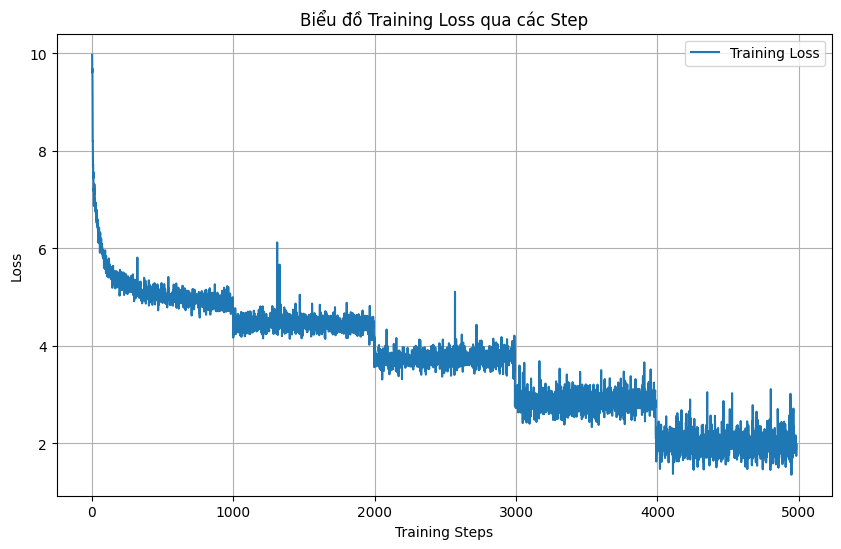

In [13]:
# @title Hiển thị biểu đồ Training Loss
import matplotlib.pyplot as plt

# Lấy dữ liệu log từ trainer
log_history = trainer.state.log_history

# Trích xuất loss và step từ mỗi entry trong log (bỏ qua entry cuối cùng có thể là thông tin tổng hợp)
steps = [log.get('step') for log in log_history if 'loss' in log]
losses = [log.get('loss') for log in log_history if 'loss' in log]

# Kiểm tra xem có dữ liệu để vẽ không
if steps and losses:
    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, label='Training Loss')
    plt.title('Biểu đồ Training Loss qua các Step')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Không tìm thấy dữ liệu loss trong log_history để vẽ biểu đồ.")

In [14]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

244.0275 seconds used for training.
4.07 minutes used for training.
Peak reserved memory = 13.039 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 88.454 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### Inference



In [45]:
input_text = "Bộ phim này thực sự là một masterpiece! Kỹ xảo điện ảnh phải nói là đỉnh cao, từng góc máy đều rất artistic. Cốt truyện ban đầu hơi chậm, but then it picks up và trở nên cực kỳ gripping. Diễn xuất của nam chính thực sự impressive, anh ấy đã lột tả nhân vật một cách xuất sắc, đặc biệt là những cảnh emotional. Có một vài plot twist khá bất ngờ, làm mình phải wow lên. Overall, đây là một bộ phim must-see trong năm nay, highly recommended!"

chosen_voice = '@W2WMovie' #@W2WMovie và @ThanhPahm

In [ ]:
#@title Run Inference (Đã sửa lỗi)

import torch
import re
import numpy as np
from typing import Dict, Any
import torchaudio.transforms as T

FastModel.for_inference(model) # Enable native 2x faster inference

@torch.inference_mode()
def generate_speech_from_text(
    text: str,
    temperature: float = 0.8,   # Generation temperature
    top_k: int = 50,            # Generation top_k
    top_p: float = 1,        # Generation top_p
    max_new_audio_tokens: int = 2048, # Max tokens for audio part
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
) -> np.ndarray:
    
    torch.compiler.reset()
    prompt = "".join([
        "<|task_tts|>",
        "<|start_content|>",
        text,
        "<|end_content|>",
        "<|start_global_token|>"
    ])
    model_inputs = tokenizer([prompt], return_tensors="pt").to(device)
    print("Generating token sequence...")
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=max_new_audio_tokens,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id
    )
    print("Token sequence generated.")
    generated_ids_trimmed = generated_ids[:, model_inputs.input_ids.shape[1]:]
    predicts_text = tokenizer.batch_decode(generated_ids_trimmed, skip_special_tokens=False)[0]
    semantic_matches = re.findall(r"<\|bicodec_semantic_(\d+)\|>", predicts_text)
    if not semantic_matches:
        print("Warning: No semantic tokens found in the generated output.")
        return np.array([], dtype=np.float32)
    pred_semantic_ids = torch.tensor([int(token) for token in semantic_matches]).long().unsqueeze(0)
    global_matches = re.findall(r"<\|bicodec_global_(\d+)\|>", predicts_text)
    if not global_matches:
         print("Warning: No global tokens found in the generated output (controllable mode). Might use defaults or fail.")
         pred_global_ids = torch.zeros((1, 1), dtype=torch.long)
    else:
         pred_global_ids = torch.tensor([int(token) for token in global_matches]).long().unsqueeze(0)
    pred_global_ids = pred_global_ids.unsqueeze(0)
    print(f"Found {pred_semantic_ids.shape[1]} semantic tokens.")
    print(f"Found {pred_global_ids.shape[2]} global tokens.")
    print("Detokenizing audio tokens...")
    audio_tokenizer.device = device
    audio_tokenizer.model.to(device)
    wav_np = audio_tokenizer.detokenize(
        pred_global_ids.to(device).squeeze(0),
        pred_semantic_ids.to(device)
    )
    print("Detokenization complete.")
    return wav_np


print(f"Generating speech for: '{input_text}' with voice '{chosen_voice}'")
# Tạo văn bản có định dạng đúng
formatted_text = f"{chosen_voice}: {input_text}" if chosen_voice else input_text

# Truyền `formatted_text` vào hàm, thay vì `input_text`
generated_waveform = generate_speech_from_text(formatted_text) 


if generated_waveform.size > 0:
    import soundfile as sf
    output_filename = "generated_speech_controllable.wav"
    sample_rate = audio_tokenizer.config.get("sample_rate", 16000)
    sf.write(output_filename, generated_waveform, sample_rate)
    print(f"Audio saved to {output_filename}")
    from IPython.display import Audio, display
    display(Audio(generated_waveform, rate=sample_rate))
else:
    print("Audio generation failed (no tokens found?).")

Generating speech for: 'Bộ phim này thực sự là một masterpiece! Kỹ xảo điện ảnh phải nói là đỉnh cao, từng góc máy đều rất artistic. Cốt truyện ban đầu hơi chậm, but then it picks up và trở nên cực kỳ gripping. Diễn xuất của nam chính thực sự impressive, anh ấy đã lột tả nhân vật một cách xuất sắc, đặc biệt là những cảnh emotional. Có một vài plot twist khá bất ngờ, làm mình phải wow lên. Overall, đây là một bộ phim must-see trong năm nay, highly recommended!' with voice '@W2WMovie'
Generating token sequence...
Token sequence generated.
Found 1214 semantic tokens.
Found 32 global tokens.
Detokenizing audio tokens...
Detokenization complete.
Audio saved to generated_speech_controllable.wav


### Saving to float16

 

In [ ]:
if True: # <-- Thay False thành True để chạy
    model.push_to_hub("huyvux3005/spark-tts-vietnamese-5hourr", token = "hf_HiZEdsnvNQXDfqWQbYvDXDfqWQbYvDxxxxxx") # thay bằng token thật
    tokenizer.push_to_hub("huyvux3005/spark-tts-vietnamese-5hourr", token = "hf_HiZEdsnvNQXDfqWQbYxxxxxxx

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Saved model to https://huggingface.co/huyvux3005/spark-tts-vietnamese-5hourr


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            



### Tài liệu tham khảo

- https://arxiv.org/abs/2503.01710 — Bài báo trên arXiv: tham khảo lý thuyết và chi tiết kỹ thuật liên quan (ví dụ LoRA, các phương pháp adapter và cơ sở toán học).
- https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning — Tài liệu chính thức của Uns­loth: hướng dẫn fine‑tuning TTS, cấu hình, và ví dụ thực hành.

Ghi chú: xem hai nguồn trên để hiểu rõ hơn về các tham số trong notebook (r, lora_alpha, lora_dropout, bias), cơ chế gradient checkpointing (bao gồm tùy chọn `"unsloth"`), LoftQ và các khuyến nghị tối ưu bộ nhớ/hiệu năng.